<a href="https://colab.research.google.com/github/Nakiyah24/ExplainableAI_Assignments/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignemnt 3
## Nakiyah Dhariwala

My Role:
💰 Case 1: Loan Approval  🟥 Prosecution

## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [1]:
!pip install lime
!pip install alibi

In [2]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lime.lime_tabular import LimeTabularExplainer
from alibi.explainers import AnchorTabular

# Load Data
from sklearn.datasets import fetch_openml

As a prosecutor, my role is to understand look at the case  and check if the model's decision was influneced by unfair reasoning when it rejected Jane DOw's application on the basis of her income level.

Throughout this report, I shall analyze the results employ two XAI techniques to ensure the model'r results lean toward fairness and unbiaseness when making credit decisions.

## Given Code Template

In [3]:
adult = fetch_openml(name="adult", version=2, as_frame=True)
df_raw = adult.frame

### Preprocessing and building Random Forest Model

In [4]:
# Clean and preprocess
df = df_raw.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include="category").columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == ">50K" else 0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



### Focus Instance

In [6]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    "age": 37,
    "workclass": encoders["workclass"].transform(["Private"])[0],
    "education": encoders["education"].transform(["Bachelors"])[0],
    "marital-status": encoders["marital-status"].transform(["Never-married"])[0],
    "occupation": encoders["occupation"].transform(["Exec-managerial"])[0],
    "relationship": encoders["relationship"].transform(["Not-in-family"])[0],
    "race": encoders["race"].transform(["White"])[0],
    "sex": encoders["sex"].transform(["Female"])[0],
    "hours-per-week": 50,
    "native-country": encoders["native-country"].transform(["United-States"])[0],
    "capital-gain": 0,
    "capital-loss": 0,
    "education-num": 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print(
    "Prediction for Jane Dow (Loan Eligibility):",
    "Approved" if pred[0] == 1 else "Denied",
)

Prediction for Jane Dow (Loan Eligibility): Denied


From the Random Forest classification report, we can see that there are perfect scores across the board (precision, recall, F1 = 1.00) but only for class 0.

That essentially means that the model is predicting everyone as earning less than or equal to 50K, with no examples of anyone earning greater than 50K. In a way, we could say that this model appears perfect, however that would be extremely misleading. Maybe this is why Jane was denied, not because of her qualifications (i.e. features) but the model itself.

Nonethless, before jumping to conclusions, I will investigate the initial model further using the LIME and Anchor methods to test whether the model truly uses any meaningful features in jane's case or not.

### Explaining Jane

#### LIME Method on current model

In [7]:
# LIME needs categorical indices & names
all_cols = X_train.columns.tolist()
cat_cols = [c for c in all_cols if c in encoders]
categorical_features = [all_cols.index(c) for c in cat_cols]
categorical_names = {all_cols.index(c): encoders[c].classes_.tolist() for c in cat_cols}


# Wrapping predict_proba so LIME sees proper column names
def predict_proba_df(x_array):
    x_df = pd.DataFrame(x_array, columns=all_cols)
    return model_adult.predict_proba(x_df)


# Building the explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=all_cols,
    class_names=["<=50K", ">50K"],
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    discretize_continuous=True,
    mode="classification",
    random_state=42,
)

# 5) explaining Jane's case
exp = explainer.explain_instance(
    data_row=jane_df.iloc[0].values,
    predict_fn=predict_proba_df,
    num_features=10,
    top_labels=1,
)

print("LIME (Current Mddel) — feature -> contribution")
for feat, weight in exp.as_list(label=exp.top_labels[0]):
    print(f"{feat}: {weight:+.3f}")

LIME (Current Mddel) — feature -> contribution
28.00 < age <= 37.00: +0.000
workclass=Private: +0.000
education=Bachelors: +0.000
10.00 < education-num <= 13.00: +0.000
marital-status=Never-married: +0.000
occupation=Exec-managerial: +0.000
relationship=Not-in-family: +0.000
race=White: +0.000
sex=Female: +0.000
capital-gain <= 0.00: +0.000


#### Anchor method (rule-style explanation) on current model

In [8]:
# predictor wrapper that returns class labels
def predict_labels_df(x_array):
    x_df = pd.DataFrame(x_array, columns=all_cols)
    return model_adult.predict(x_df)


# 3) creating & fitting the explainer
anchor_exp = AnchorTabular(
    predictor=predict_labels_df,
    feature_names=all_cols,
    categorical_names=categorical_names,
)
anchor_exp.fit(X_train.values, disc_perc=[25, 50, 75])

# 4) explaining Jane
anchor = anchor_exp.explain(jane_df.iloc[0].values, threshold=0.95)

print("ANCHOR (Current Model) — rule:", anchor.anchor)
print("Precision:", anchor.precision)
print("Coverage:", anchor.coverage)

ANCHOR (Current Model) — rule: []
Precision: [1.]
Coverage: 1


My analysis from LIME and Anchor:

In the LIME output, we can see that every feature has a contribution of +0.000 which simply means that LIME can't identify any feature influencing Jane's denial.


In addition, Anchor could also not find a condition (i.e. []) to explain Jane's outcome. Precision and COverage of 1 essentially indicate that anyone and everyone is always 'Denied'.

Thus, both LIME and Anchor fail to produce meaningful explanations which is concerning because if two independent XAI models fail to produce meaningful reasoning, it wouldn't matter if Jane was educated, worked higher hours per week, etc. - the model will always deny her.

As we saw from the classification report above, precision, recall and f1 all resulted in a 1 for class 0, which simply reinforces my belief that the issue lies not with Jane’s profile but with the data, preprocessing, or the model itself. My next step would be to go back to EDA.

### Further Inspection

In [9]:
# A) Overall target distribution for y
print("Overall counts:\n", y.value_counts())
print("\nOverall proportions:\n", y.value_counts(normalize=True))
print("\nUnique labels in y:", sorted(y.unique()))

Overall counts:
 class
0    45222
Name: count, dtype: int64

Overall proportions:
 class
0    1.0
Name: proportion, dtype: float64

Unique labels in y: [0]


In [10]:
# Looking at the existing Train/Test target distribution
for name, arr in [("y_train", y_train), ("y_test", y_test)]:
    print(f"\n{name} counts:\n", arr.value_counts())
    print(f"\n{name} proportions:\n", arr.value_counts(normalize=True))


y_train counts:
 class
0    36177
Name: count, dtype: int64

y_train proportions:
 class
0    1.0
Name: proportion, dtype: float64

y_test counts:
 class
0    9045
Name: count, dtype: int64

y_test proportions:
 class
0    1.0
Name: proportion, dtype: float64


Based on the counts and distribution, we can see that both - the y_train and y_test - contain only class 0. This means, the model was only trained on <= 50K. This further explains why LIME and Anchors could not produce any meaningful explanations — the model simply defaults to denial for everyone.

By looking at the precproocessing code above, I saw that the target column of 'class' is being label-encoded first and then y is being built by comparing the label encoded integers to the string ">50K". Now since that comparison is always False, all labels will become 0 and, thus, the model will only learn to predict <=50K.

TO fix this, we need to remove 'class' from being encoded and build y correctly. After that we can check the model perfomance using the uncorrupted y variable.

## New preprocessing code

### Preprocessing and building Random Forest Model

In [11]:
# Clean and preprocess (FIXED)
df = df_raw.dropna().copy()

# Create target from the raw string labels (before any encoding)
y = (df["class"] == ">50K").astype(int)

# Label-encode ONLY the feature columns
# excluding the target
encoders = {}
label_cols = df.select_dtypes(include="category").columns.tolist()
label_cols = [c for c in label_cols if c != "class"]

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Build features from the same cleaned df
X = df.drop(["class", "fnlwgt"], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
# Train and Check model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)

print("\nClassification report:")
print(classification_report(y_test, model_adult.predict(X_test)))


Classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6842
           1       0.72      0.61      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.80      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045



In [13]:
# Check ditribution now

print("Train distribution:\n", y_train.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))

Train distribution:
 class
0    0.751085
1    0.248915
Name: proportion, dtype: float64

Test distribution:
 class
0    0.75644
1    0.24356
Name: proportion, dtype: float64


### Focus Instance

In [14]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    "age": 37,
    "workclass": encoders["workclass"].transform(["Private"])[0],
    "education": encoders["education"].transform(["Bachelors"])[0],
    "marital-status": encoders["marital-status"].transform(["Never-married"])[0],
    "occupation": encoders["occupation"].transform(["Exec-managerial"])[0],
    "relationship": encoders["relationship"].transform(["Not-in-family"])[0],
    "race": encoders["race"].transform(["White"])[0],
    "sex": encoders["sex"].transform(["Female"])[0],
    "hours-per-week": 50,
    "native-country": encoders["native-country"].transform(["United-States"])[0],
    "capital-gain": 0,
    "capital-loss": 0,
    "education-num": 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print(
    "Prediction for Jane Dow (Loan Eligibility):",
    "Approved" if pred[0] == 1 else "Denied",
)

Prediction for Jane Dow (Loan Eligibility): Denied


This time, as we can see from above, the model is no longer "perfect" - the performance is more realistic.
Nonetheless, the model is biased toward denial because of class imbalance. It performs significantly worse on those earning >50K cases, meaning qualified applicants like Jane are more likely to be wrongfully denied.

Now I can look at the LIME and Anchors method again to figure out which features are pushing Jane toward denial and what rule-like conditions summarize the decision.

### Explaining Jane on new code

#### LIME Method on new model

In [15]:
# feature names and categorical info
all_cols = X_train.columns.tolist()
cat_cols = [c for c in all_cols if c in encoders]
categorical_features = [all_cols.index(c) for c in cat_cols]
categorical_names = {all_cols.index(c): encoders[c].classes_.tolist() for c in cat_cols}


# wrap predict_proba so LIME gets the right column names back
def predict_proba_df(x_array):
    x_df = pd.DataFrame(x_array, columns=all_cols)
    return model_adult.predict_proba(x_df)


# build explainer
explainer_fixed = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=all_cols,
    class_names=["<=50K", ">50K"],
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    discretize_continuous=True,
    mode="classification",
    random_state=42,
)

# explain Jane
proba = model_adult.predict_proba(jane_df)[0]  # Function taken from above
print("Jane probabilities (<=50K, >50K):", proba)

Jane probabilities (<=50K, >50K): [0.69666667 0.30333333]


In [16]:
exp_fixed = explainer_fixed.explain_instance(
    data_row=jane_df.iloc[0].values,
    predict_fn=predict_proba_df,
    num_features=10,
    top_labels=1,
)

print("\nLIME (fixed) — feature -> contribution")
for feat, weight in exp_fixed.as_list(label=exp_fixed.top_labels[0]):
    print(f"{feat}: {weight:+.3f}")


LIME (fixed) — feature -> contribution
capital-gain <= 0.00: +0.595
capital-loss <= 0.00: +0.100
hours-per-week > 45.00: -0.094
marital-status=Never-married: +0.071
10.00 < education-num <= 13.00: -0.062
occupation=Exec-managerial: -0.060
relationship=Not-in-family: +0.050
sex=Female: +0.017
education=Bachelors: -0.006
race=White: +0.004


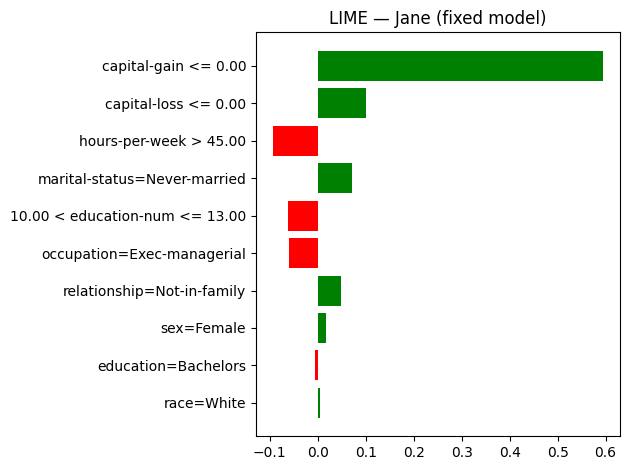

In [17]:
fig = exp_fixed.as_pyplot_figure(label=exp_fixed.top_labels[0])
plt.title("LIME — Jane (fixed model)")
plt.tight_layout()
plt.show()

#### Anchor method (rule-style explanation) on new model

In [18]:
# create and fit explainer
anchor_exp_fixed = AnchorTabular(
    predictor=predict_labels_df,
    feature_names=all_cols,
    categorical_names=categorical_names,
)
anchor_exp_fixed.fit(X_train.values, disc_perc=[25, 50, 75])

# explain Jane
anchor_fixed = anchor_exp_fixed.explain(jane_df.iloc[0].values, threshold=0.95)

print("ANCHOR (fixed) — rule:", anchor_fixed.anchor)
print("Precision:", anchor_fixed.precision)
print("Coverage:", anchor_fixed.coverage)

ANCHOR (fixed) — rule: ['relationship = Not-in-family', 'marital-status = Never-married']
Precision: 0.9530791788856305
Coverage: 0.1467


Analysis of the Mathods basd on the new model:


For Jane’s case, the model predicted a 69.7% probability of her earning less than (or equal to) 50K and only a 30.3% chance of greater than 50K - resulting in her loan denial.

The LIME model shows that the strongest factor pushing her toward denial was reporting no capital gains, followed by smaller effects from no capital losses, her never-married status, and not-in-family relationship status. Even demographic features like sex and race contributed slightly toward denial. Meanwhile, her positive factors such as her long work hours, bachelor’s degree, and executive occupation pushed her toward approval, but not enough to outweigh the negatives. This strongly shows that the model is placing disproportionate weight on weaker or irrelevant signals rather than key indicators of earning power.

Anchor further reinforces this problem. The rule revelas that if an applicant’s relationship is “not-in-family” and their marital status is “never-married,” the model almost always predicts they earn less than (or equal to) 50K, with a precision of about 95.3%. This reduces Jane’s profile to demographic attributes and ignores her real qualifications ike her education and occupation.


The overall problem that LIME and Anchor both highlight is that Jane’s denial is being driven by demographic and social status factors, while her positive (that are more financial oriented) attributes — such as her executive occupation, education, and long work hours — are overlooked. This highlights how the model makes unfair biases, reducing her profile to a couple of categorical conditions rather than evaluating her full qualifications.


However, the problem does not end there. Even if we were to assume that the model made a decision fairly and accurately - taking into account important variables like education and occupation over the non-financial status - the model is incorrect to begin with. This is because of the error that was present in the preprocessing stage where it classified the target 'class' variable as a categorical variable and encoded that column. This collapsed the target values and caused the model to see the outcome labels incorrectly.


Simply put, the model was not just biased in its reasoning - it was trained on a corrupted target variable from the beginning. Thus, any decision it made, including Jane's denial (the first time) were built on the wrong ground truth. This makes the model not only unfair but also unreliable at a fundamental level, and had we not made more post-modeling checks or done more analysis, we would have trusted a model that never actually learned the true distinction between applicants earning greater than 50K and those earning less than (or equal to) 50K.

To conclude, I propose that this model is doubly unfit for deployment.

First, explainability methods like LIME and Anchors reveal that the model's results rest on biases.
- LIME shows the decision rests primarily on no capital gains/losses and family status;
- Anchors proves that Never-married + Not-in-family alone drives denial with approximately 95% precision.

Neither rationale reflects ability-to-repay. The inclusion and influence of sex/race/familial relationships further violates fair-lending norms. This decision, and the model behind it, fail the standard of a fair credit decision.


Secondly, and perhaps most importantly, the model itself is built and trained on the wrong foundation - an error in the preprocessing stage that corrupted the target variable.

In combination, these flaws make the model both biased in its reasoning and invalid in its training (the first model, not the corrected one). Any loan decisions it produces, including Jane’s denial, cannot be considered fair, transparent, or trustworthy.

End Comments: I used ChatGPT-5 to help with the coding (specifically for LIME and Achors) and making the plots for LIME.